In [2]:
pip install -r requirements.txt

  Using cached pandas-1.5.2-cp38-cp38-win_amd64.whl (11.0 MB)
     ---------------------------------------- 9.2/9.2 MB 14.7 MB/s eta 0:00:00
     ---------------------------------------- 6.3/6.3 MB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------- 288.2/288.2 kB 17.4 MB/s eta 0:00:00
  Using cached tk-0.1.0-py3-none-any.whl (3.9 kB)
     ---------------------------------------- 58.4/58.4 kB 3.0 MB/s eta 0:00:00
  Using cached idna-2.10-py2.py3-none-any.whl (58 kB)
     -------------------------------------- 128.0/128.0 kB 7.4 MB/s eta 0:00:00
     -------------------------------------- 133.4/133.4 kB 7.7 MB/s eta 0:00:00
  Using cached Pympler-1.0.1-py3-none-any.whl (164 kB)
  Using cached altair-4.2.0-py3-none-any.whl (812 kB)
  Using cached semver-2.13.0-py2.py3-none-any.whl (12 kB)
     ---------------------------------------- 237.5/237.5 kB ? eta 0:00:00
  Using cach

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.1 which is incompatible.


## １各職種の年収データを収集する。

In [19]:
import selenium
from selenium.webdriver.chrome.service import Service
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from statistics import mean
import pandas as pd
import numpy as np
import time
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support.select import Select

options = webdriver.ChromeOptions()
options.add_argument('--disable-gpu')
options.add_argument("--force-device-scale-factor=1")
options.add_argument("--enable-features=NetworkServiceInProcess")
options.add_experimental_option('extensionLoadTimeout', 60000)

In [20]:
def get_data_indeed():
    # 5つの職種について、データ収集を行う。
    list = ["データエンジニア", "データアナリスト", "データサイエンティスト", "機械学習エンジニア", "データアーキテクト"]

    # 4つのデータを収集する。
    jobs = []
    salaries_min = []
    salaries_max = []
    salaries_mean = []
    
    # indeedの検索ページを呼び出す。
    driver=webdriver.Chrome()
    url='https://jp.indeed.com/?from=gnav-jobsearch--indeedmobile'
    driver.get(url)
    driver.maximize_window()
    
    
    # 職種を一つ一つ入力して、検索する。
    for key in list: # 職種を入力する。
        input = driver.find_element(By.ID, 'text-input-what')
        input.send_keys(key + " 正社員")
        time.sleep(1)
        search = driver.find_element(By.CLASS_NAME, 'yosegi-InlineWhatWhere-primaryButton')
        search.click() # 検索する。
        time.sleep(2)
        
        while True: #求人票のデータを収集する。
            for elem in driver.find_elements(By.CSS_SELECTOR, '[class="resultContent"]'):
                job_title = elem.find_element(By.CSS_SELECTOR, '[class="css-1m4cuuf e37uo190"]')
                if key in job_title.text: # 職名を絞る。
                    try:
                        salary = elem.find_element(By.CSS_SELECTOR, '[class="metadata salary-snippet-container"]') # 収入を見つける。
                        if "年収" in salary.text: # 年収データを残す。
                            a = salary.text
                            b = a.replace("年収", '').replace('万円', '').replace(',', '').replace('以上', '').replace(' ', '')
                            c = [int(n) for n in b.split("~")]
                            # データをデータセットに追加する。
                            salaries_min.append(min(c))     
                            salaries_max.append(max(c))
                            salaries_mean.append(mean(c))
                            jobs.append(key)
                    except NoSuchElementException: # 年収データが表示されていない求人票もあるので、無視して次の求人票に移る。
                        continue
             
            # 次のページへ移る。
            try:
                next_page = driver.find_element(By.CSS_SELECTOR, '[aria-label="次へ"]')
            except NoSuchElementException:
                try:
                    next_page = driver.find_element(By.CSS_SELECTOR, '[aria-label="Next Page"]')
                except NoSuchElementException: # 次のページがなくなると、検索が終わる。
                    break
            driver.execute_script('arguments[0].click();', next_page)
            time.sleep(2)
            
        # 一つの職種についての検索が終わると、indeedの検索ページに戻って、次の職種について検索する。 
        try:
            indeed = driver.find_element(By.CLASS_NAME, 'gnav-Logo-icon')
        except ElementClickInterceptedException:
            close_button = driver.find_element(By.CLASS_NAME, "popover-x-button-close icl-CloseButton")
            close_button.click()
            indeed = driver.find_element(By.CLASS_NAME, 'gnav-Logo-icon')
        indeed.click()
        time.sleep(2)

        continue

    # データを整理する。                    
    df = pd.DataFrame({'職種': jobs,
                       '年収_min': salaries_min,
                       '年収_max': salaries_max,
                       '年収_mean': salaries_mean
                      })

    return df

In [22]:
# データ収集を実行する。
data_indeed = get_data_indeed()

In [12]:
# データセットを保存する。
data_indeed.to_csv("indeed_data.csv", index=None)

In [13]:
# データセットを読み込む。
data = pd.read_csv("indeed_data.csv")

In [30]:
# データセットの記述。
describe = data[['職種','年収_mean']].groupby(['職種']).describe()
describe

年収_mean                                                       \
              count        mean         std    min    25%     50%    75%   
職種                                                                         
データアナリスト      304.0  681.268092  166.347452  276.0  550.0  700.00  800.0   
データアーキテクト      45.0  753.511111  143.833177  525.0  625.0  750.00  850.0   
データエンジニア       42.0  870.940476  141.950232  415.0  762.5  960.00  960.0   
データサイエンティスト   423.0  783.401891  231.086819  350.0  625.0  750.00  900.0   
機械学習エンジニア      60.0  813.558333  189.756648  415.0  700.0  812.25  950.0   

                     
                max  
職種                   
データアナリスト     1400.0  
データアーキテクト    1000.0  
データエンジニア      975.0  
データサイエンティスト  2149.5  
機械学習エンジニア    1424.5

## 2各職種の年収データをプロットする。

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='Yu Gothic')

<Figure size 800x640 with 0 Axes>

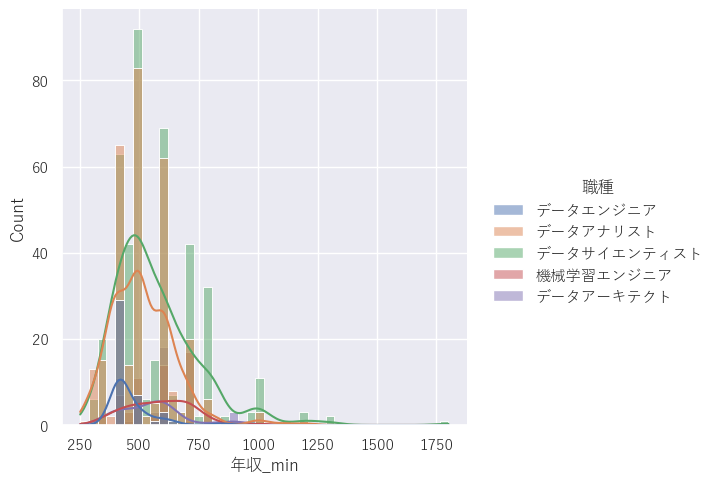

In [16]:
# 各職種の最小年収をプロットする。
chart_min = plt.figure(figsize=(10, 8), dpi=80)
sns.displot(data=data, x="年収_min", hue="職種", kde=True)   

<Figure size 800x640 with 0 Axes>

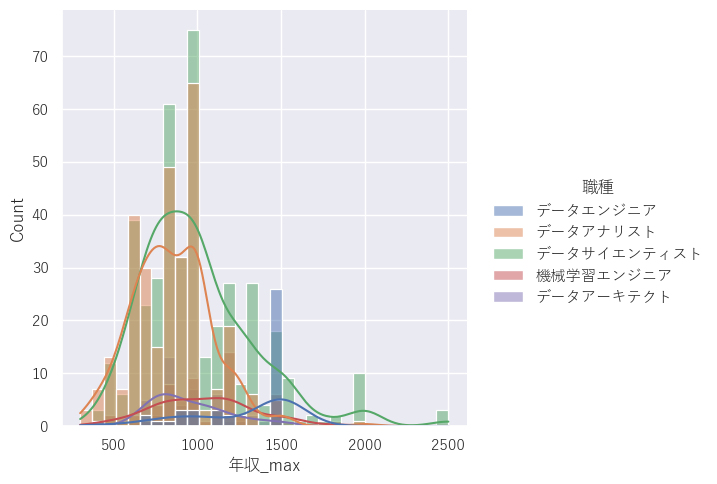

In [17]:
# 各職種の最大年収をプロットする。
chart_max = plt.figure(figsize=(10, 8), dpi=80)
sns.displot(data=data, x="年収_max", hue="職種", kde=True)

<Figure size 800x640 with 0 Axes>

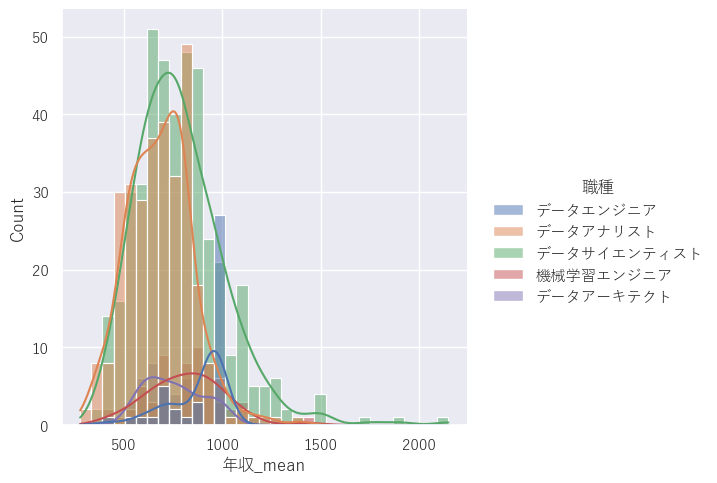

In [18]:
# 各職種の平均年収をプロットする。
chart_mean = plt.figure(figsize=(10, 8), dpi=80)
sns.displot(data=data, x="年収_mean", hue="職種", kde=True)